# Critical Collapse Study

Below is code to help study the formation of black holes. The equations integrated are described in the work by Bloomfield et. al.

arXiv paper on : [1504.02071](https://arxiv.org/pdf/1504.02071.pdf) ([ar5iv](https://ar5iv.org/abs/1504.02071))

For collapse with an approximate QCD equation of state, a previous work is

arXiv: [1801.06138](https://arxiv.org/pdf/1801.06138.pdf) ([ar5iv](https://ar5iv.org/abs/1801.06138))

## Import Modules

In [25]:
import numpy as np
import sys
from importlib import reload 
import scipy.interpolate as interp
import scipy.constants as const

import cython
%load_ext Cython

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


## Import MS, HM modules

...and reload modules if needed

In [26]:
# importing MS and HM modules. Reload modules if needed
try :
    reload(ms_hm.MS)
    reload(ms_hm.HM)
    reload(ms_hm.QCD_EOS)
except :
    print("Did not reload modules")

import ms_hm
from ms_hm.QCD_EOS import *
from ms_hm.MS import *
from ms_hm.HM import *

## Various functions that use the MS and HM classes

Functions below compute various things using the Misner-Sharp or Hernandez-Misher classes.

In [27]:
%%cython

import cython
cimport numpy as np

cimport cython
ctypedef np.double_t DTYPE_t

from libc.math cimport exp
from libc.math cimport sqrt

from cython.parallel import prange

@cython.boundscheck(False)  # Deactivate bounds checking
cpdef zero_crossing(np.ndarray x_in, double [::1] y):
    """
    Given an array of inputs y, find x where the function y(x) = 0
    """
    cdef int size = x_in.shape[0]
    cdef double [:] x = x_in
    cdef double w, zero=-1
    cdef int i
    
    for i in range(size-1): # loop through all y values
        if(y[i] * y[i+1] < 0): # if subsequent elements have opposite signs, a zero-crossing was found.
            # linearly extrapolate zero-crossing
            w = abs(y[i] / (y[i+1] - y[i])) 
            zero = x[i] * (1 - w) + x[i+1] * w
            break
            
    return zero

In [28]:
def mix_grid(left, right, n):
    """
    Function to generate coordinate spacings with a mix of uniform and logarithmic spacings,
    with uniform spacing at small values (0 to "left") then logarithmically spaced ("left" to "right").
    
    Returns an array of coordinate positions.
    """
    
    # Generate logarithmically spaced coordinates between "left" and "right"
    A = np.exp(np.linspace(left, right, n))
    dA = A[1] - A[0]
    
    # Generate uniformly spaced coordinates
    A = np.concatenate( (np.linspace(0, A[0], int(np.ceil(A[0] / dA)), endpoint=False), A))
    
    return A

def uni_grid(right, n):
    """
    Function to generate a uniformly-spaced array of coordinate positions
    
    Returns the array of uniformly spaced coordinates.
    """
    A = np.linspace(0, np.exp(right), n)
    return A

def exp_grid(left, right, n):
    """
    Function to generate an exponentially-spaced array of coordinate positions
    """
    # Generate logarithmically spaced coordinates between "left" and "right"
    A = np.logspace(left, right, n)
    A = np.concatenate( ([0], A))

    return A

In [29]:
# Check if a BH forms
# The MS run should proceed until MS until it breaks. If 2m / R > 1, return true
def BH_form(Abar, rho0, amp, default_steps=1500000, sm_sigma=0.0):
    
    ms = MS(Abar, rho0, amp, trace_ray=False, BH_threshold=-1, sm_sigma=sm_sigma)
    
    if (ms.adap_run_steps(default_steps) == -1):
        return (True, ms.delta, ms)
    
    return (False, ms.delta, ms)

In [30]:
def find_crit(Abar, rho0, lower_amp, upper_amp, sm_sigma=0.0):
    """
    Binary search between lower and upper to find a critical amplitude
    (Note that this is NOT the critical density)
    return (critical, upper value)
    """
    
    upper_ms = -1
    lower_ms = -1
    for i in range(20):
        middle_amp = (lower_amp + upper_amp) / 2
        print('Iteration No', str(i), '-- Checking to see if a BH forms at amplitude', str(middle_amp))

        try :
            forms, delta, ms = BH_form(Abar, rho0, middle_amp, sm_sigma=sm_sigma)
        except Exception as e :
            print("Run failed with amplitude", middle_amp, "! Stopping search. Reason below.")
            print(e)
            break
        
        if(forms == True):
            upper_amp = middle_amp
            upper_ms = ms
        else:
            lower_amp = middle_amp
            lower_ms = ms
    
    print("Critical amplitude appears to be between", lower_amp, "and", upper_amp)
    upper_ms.plot_fields(True)
    lower_ms.plot_fields(True)
    return (lower_amp, upper_amp)

In [31]:
def find_mass(Abar, rho0, amp, is_searching_for_crit=False, default_steps=1500000):
    """
    Find mass of BHs for certain amplitude
    set is_searching_for_crit=True when searching for the critical point
    """
    print('Finding mass with amp ' + str(amp))
            
    # Perform a MS run without raytracing
    ms = MS(Abar, rho0, amp, trace_ray=False, BH_threshold=-1e1)
    ms.run_steps(default_steps)
    delta = ms.delta
    
    # Perform a run *with* raytracing to get ICs for an HM run
    ms = MS(Abar, rho0, amp, trace_ray=True, BH_threshold=-1e1)
    flag = ms.run_steps(default_steps)
    if(flag != 0):
        raise ValueError('Not finishing ray-tracing with the amplitude ' + str(amp))
        
    # Perform an HM run
    hm = HM(ms, mOverR=0.99, sm_sigma=50)
    bh_formed = hm.adap_run_steps(550000) == 1
    if(not bh_formed and is_searching_for_crit==False):
        raise ValueError('Cannot get the target 2m/R with the amplitude ' + str(amp))
    
    print(ms.delta, hm.BH_mass2())
    return (ms.delta, hm.BH_mass2())

In [32]:
# # Generate critical scaling data 
# def critical_scaling(crit_amp, lower_amp, upper_amp, n=10):
#     amps = 10**np.linspace(np.log10(lower_amp - crit_amp), np.log10(upper_amp - crit_amp), n) + crit_amp
#     print(amps)
#     masses = np.array([find_mass(amp) for amp in amps])
#     crit_delta = find_mass(crit_amp, is_searching_for_crit=True)[0]  
#     return (masses, crit_delta)

## Simulation setup

Code below will set up grids (arrays) for running the simulations.

The grid of Abar values is linearly spaced from Abar = 0 to 0.5476822525425332 then log spaced until Abar = 3.673077974307203


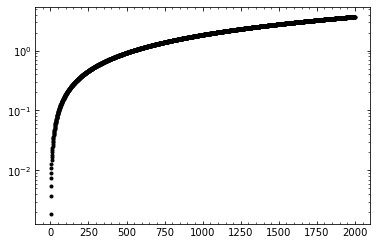

In [33]:
# simulation resolution parameter
# (Not exactly the number of gridpoints for a mixed grid)
n = 2000

# Generate an array of coordinate positions for the simulation to run at
lower = np.log10(0.25) # The coordinates will be linearly spaced from 0 to e^lower
upper = np.log10(20) # The coordinates will be log spaced from e^lower to e^upper
# Abar = mix_grid(lower, upper, n)
# Abar = exp_grid(lower, upper, n)
Abar = uni_grid(upper, n)
plt.semilogy(Abar, 'k.')
print("The grid of Abar values is linearly spaced from Abar = 0 to", np.exp(lower),
      "then log spaced until Abar =", np.exp(upper))

## Scratch Work

Below is some scratch work useful for testing simulations and getting things set up to run

Initial w is 0.3333333333333333 and Horizon radius is 7.725484040463792e-10
Not Tracing ray and NO excision will be performed!
Horizon is found, code will be terminated! Finished at step 63056


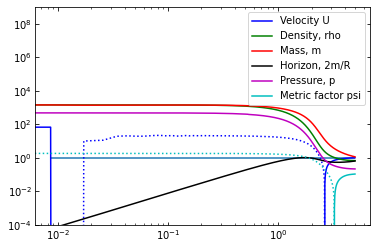

In [43]:
# Reload MS module and try a run
reload(ms_hm.QCD_EOS)
from ms_hm.QCD_EOS import *
reload(ms_hm.MS)
from ms_hm.MS import *
rho0 = 2.0e17 # initial density value in MeV^4, should just be w=1/3 here.
amp = 0.30

ms = MS(Abar, rho0, amp, trace_ray=False, BH_threshold=-999, sm_sigma=2.0)
ms.adap_run_steps(200000)
ms.plot_fields(True)

In [ ]:
QCD_EOS().fix_w(1e6)

In [42]:
n = 200
Abar = mix_grid(np.log10(1.5), np.log10(40), n)
rho0 = 1.0e19# initial density value in MeV^4
find_crit(Abar, rho0, 0.15, 0.3,sm_sigma = 2.0)

Iteration No 0 -- Checking to see if a BH forms at amplitude 0.22499999999999998
Initial w is 0.3333333333333333 and Horizon radius is 3.4549414947133547e-10
Not Tracing ray and NO excision will be performed!
Density near origin has dropped significantly, so a black hole likely won't be forming! This occurred at step 87500
Iteration No 1 -- Checking to see if a BH forms at amplitude 0.26249999999999996
Initial w is 0.3333333333333333 and Horizon radius is 3.4549414947133547e-10
Not Tracing ray and NO excision will be performed!
Density near origin has dropped significantly, so a black hole likely won't be forming! This occurred at step 108849
Iteration No 2 -- Checking to see if a BH forms at amplitude 0.28125
Initial w is 0.3333333333333333 and Horizon radius is 3.4549414947133547e-10
Not Tracing ray and NO excision will be performed!


KeyboardInterrupt: 

In [ ]:
rho0val = np.array([1e1,1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9,1e10,1e11,1e12,1e13,1e14,1e15,1e16,1e17,1e18])
lowerbound = np.array([0.2724609375,0.2724609375,0.2724609375,0.2724609375,0.27158203124999997,0.26923828125,0.2630859375,0.2643310546874999,0.25925903320312493,0.23671073913574214,0.259423828125,0.26030273437499996, 0.2666015625,0.27041015625,0.27041015625,0.26953125,0.271875,0.2724609375])
upperbound = np.array([0.27304687499999997,0.27304687499999997,0.27304687499999997,0.27304687499999997,0.271875,0.26953125,0.26315917968749997,0.2644042968749999,0.25927734374999994,0.2367108821868896,0.25946044921875,0.26033935546875,0.26718749999999997,0.27055664062499996,0.270703125,0.271875,0.27304687499999997,0.27304687499999997])
plt.semilogx(rho0val,upperbound)
plt.semilogx(rho0val,lowerbound)
rho0valqcd = np.array([1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9,1e10,1e11,1e12,1e13,1e14,1e15,1e16])
lowerboundqcd = np.array([0.27187500000000003,0.27265625000000004, 0.27265625000000004,0.27255859375,0.27167968750000004,0.26904296875,0.265625,0.26298828125000007,0.2580078125,0.25078125,0.24492187499999998,0.261328125,0.264794921875,0.2701660156250001,0.27031250000000007])
upperboundqcd = np.array([0.275,0.273046875,0.27285156250000003,0.27265625000000004,0.27187500000000003,0.269140625,0.26640625,0.26308593750000003,0.258056640625,0.2509765625,0.2453125,0.26171875,0.26480712890624997,0.27019042968750007,0.27187500000000003])
plt.semilogx(rho0valqcd,upperboundqcd)
plt.semilogx(rho0valqcd,lowerboundqcd)

In [ ]:
rho0valnew = np.array([1,5.5,1e1,5.5e1,1e2,5.5e2,1e3,5.5e3,1e4,5.5e4,1e5,5.5e5,1e6,5.5e6,1e7,5.5e7,1e8,5.5e8,1e9,1e10,5.5e10,1e11,5.5e11,1e12,5.5e12,1e13,5.5e13,1e14,5.5e14,1e15,5.5e15,1e16,5.5e16,1e17,5.5e17,1e18,5.5e18,1e19,5.5e19,1e20,5.5e20,1e21,5.5e21,1e22,5.5e22,1e23])
lower = np.array([0.27265625000000004, 0.27265625000000004,0.27265625000000004,0.27265625000000004,0.27265625000000004,0.27265625000000004,0.27265625000000004,0.27265625000000004,0.27265625000000004,0.27187500000000003,0.27167968750000004,0.2699218750000001,0.26933593750000007,0.265087890625,0.26308593750000003,0.263720703125,0.26435546874999993, 0.264697265625,0.25926513671875,0.23671417236328124,0.25898437500000004,0.25943603515625,0.25986328125,0.26031494140625,0.2640625,0.26679687500000004,0.27031250000000007,0.27031250000000007,0.27031250000000007,0.27031250000000007,0.27050781250000006,0.27031250000000007,0.271484375,0.27246093750000006,0.27265625000000004,0.27265625000000004,0.27265625000000004,0.27265625000000004,0.27265625000000004,0.27265625000000004,0.27265625000000004,0.27265625000000004,0.27265625000000004,0.27265625000000004,0.27265625000000004,0.27265625000000004])
upper = np.array([0.27285156250000003,0.27285156250000003,0.27285156250000003,0.27285156250000003,0.27285156250000003,0.27285156250000003,0.27285156250000003,0.27285156250000003,0.27285156250000003,0.27265625000000004,0.27187500000000003,0.2700195312500001,0.26953125000000006,0.2651123046875,0.26318359375,0.26376953125,0.2643798828124999,0.26474609375,0.25927734375,0.23671426773071289,0.2590087890625,0.25944824218750007,0.25991210937500003,0.26032714843750004,0.264111328125,0.26699218750000003,0.27070312500000004,0.27070312500000004,0.27070312500000004,0.27070312500000004,0.27070312500000004,0.27109375,0.27167968750000004,0.27265625000000004,0.273046875,0.273046875,0.273046875,0.273046875,0.273046875,0.273046875,0.273046875,0.273046875,0.273046875,0.273046875,0.273046875,0.273046875])
plt.semilogx(rho0valnew,upper)
plt.semilogx(rho0valnew,lower)

In [ ]:
rho0_val = np.array([3.25e1,4.375e1,5.5e1,6.625e1,7.75e1,8.875e1,1e2,2.125e2,3.25e2,4.375e2,5.5e2,6.625e2,7.75e2,8.875e2,1e3,2.125e3,3.25e3,4.375e3,5.5e3,6.625e3,7.75e3,8.875e3,1e4,2.125e4,3.25e4,4.375e4,5.5e4,6.625e4,7.75e4,8.875e4,1e5,2.125e5,3.25e5,4.375e5,5.5e5,6.625e5,7.75e5,8.875e5,1e6,2.125e6,3.25e6,4.375e6,5.5e6,6.625e6,7.75e6,8.875e6,1e7,2.125e7,3.25e7,4.375e7,5.5e7,6.625e7,7.75e7,8.875e7,1e8,2.125e8,3.25e8,4.375e8,5.5e8,6.625e8,7.75e8,8.875e8,1e9,2.125e9,3.25e9,4.375e9,5.5e9,6.625e9,7.75e9,8.875e9,1e10,2.125e10,3.25e10,4.375e10,5.5e10,6.625e10,7.75e10,8.875e10,1e11,2.125e11,3.25e11,4.375e11,5.5e11,6.625e11,7.75e11,8.875e11,1e12,2.125e12,3.25e12,4.375e12,5.5e12,6.625e12,7.75e12,8.875e12,1e13,2.125e13,3.25e13,4.375e13,5.5e13,6.625e13,7.75e13,8.875e13,1e14,2.125e14,3.25e14,4.375e14,5.5e14,6.625e14,7.75e14,8.875e14,1e15,2.125e15,3.25e15,4.375e15,5.5e15,6.625e15,7.75e15,8.875e15,1e16,2.125e16,3.25e16,4.375e16,5.5e16,6.625e16])
lowerqcd = np.array([0.27421875,0.2734375,0.273828125,0.2736328125,0.2734375,0.2734375,0.27187500000000003,0.27265625000000004,0.27285156250000003,0.27285156250000003,0.27285156250000003,0.27265625000000004,0.27265625000000004,0.27265625000000004,0.27265625000000004,0.27275390625000007,0.27265625000000004,0.27265625000000004,0.27265625000000004,0.27265625000000004,0.27265625000000004,0.27265625000000004,0.27265625000000004,0.27265625000000004,0.27265625000000004,0.27265625000000004,0.27187500000000003,0.27187500000000003,0.27187500000000003,0.27187500000000003,0.27255859375,0.2723632812500001,0.27187500000000003,0.2720703125,0.27197265625,0.27187500000000003,0.26875000000000004,0.27177734375000007,0.27167968750000004,0.27119140625000004,0.27070312500000004,0.27031250000000007,0.2699218750000001,0.26972656250000004,0.26875000000000004,0.26923828125000004,0.26904296875,0.2671875,0.2671875,0.26699218750000003,0.26640625,0.26640625,0.265625,0.266015625,0.265625,0.26494140624999996,0.26435546874999993,0.26396484374999996,0.263671875,0.2634765625,0.26328125,0.26308593750000003,0.26298828125000007,0.26093750000000004,0.2606445312500001,0.25986328125,0.25917968750000003,0.2587890625,0.25847167968750007,0.258203125,0.2580078125,0.25694580078125,0.2561279296875,0.2552734375,0.25439453125,0.25349121093750004,0.25253906249999997,0.25166015625000004,0.25078125,0.2453125,0.24375,0.2431640625,0.2431640625,0.243359375,0.24375,0.24375,0.24492187499999998,0.250390625,0.25390625,0.25664062499999996,0.258203125,0.259375,0.2603515625,0.26103515625000007,0.261328125,0.2631905555725098,0.26358337402343746,0.2638214111328125,0.26401367187499997,0.26423339843749993,0.2644287109375,0.264599609375,0.264794921875,0.2662353515625,0.26727294921875006,0.26806640625,0.26868896484375004,0.269140625,0.26958007812500007,0.2699096679687501,0.2701660156250001,0.271240234375,0.27138671875,0.2712890625,0.2712890625,0.27119140625000004,0.27114257812500003,0.27109375,0.271044921875,0.27080078125000007, 0.27070312500000004,0.27070312500000004,0.27080078125000007,0.27031250000000007])
upperqcd = np.array([0.275,0.275,0.2740234375,0.273828125,0.273828125,0.2736328125,0.275,0.2734375,0.273046875,0.273046875,0.27294921875,0.273046875,0.273046875,0.273046875,0.273046875,0.27285156250000003,0.27285156250000003,0.27285156250000003,0.27285156250000003,0.27285156250000003,0.27285156250000003,0.27285156250000003,0.27285156250000003, 0.27285156250000003,0.27285156250000003,0.27275390625000007,0.2734375,0.2734375,0.2734375,0.2734375,0.27265625000000004,0.27246093750000006,0.27265625000000004,0.27216796875000004,0.2720703125,0.2720703125,0.275,0.27187500000000003,0.27187500000000003,0.2712890625,0.27089843750000003,0.27050781250000006,0.27031250000000007,0.2699218750000001,0.27031250000000007,0.26933593750000007,0.269140625,0.26875000000000004,0.267578125,0.2671875,0.2671875,0.26679687500000004,0.2671875,0.26640625,0.26640625,0.2650390625,0.26445312499999996,0.2640625,0.2638671875,0.263671875,0.2634765625,0.26328125,0.26308593750000003,0.2625,0.26074218750000006,0.25996093750000004,0.259375,0.258837890625,0.25849609375000004,0.258251953125,0.258056640625,0.2569580078125,0.25615234374999996, 0.255322265625,0.25444335937499996,0.253515625,0.25263671874999993,0.2517578125,0.2509765625,0.24609375,0.2439453125,0.243359375,0.243359375,0.24375,0.244140625,0.2453125,0.2453125,0.25078125,0.25468749999999996,0.25703125,0.25859375,0.259765625,0.26054687500000007,0.26113281250000003,0.26171875,0.26319065093994143,0.26358413696289057,0.263824462890625,0.2640625,0.26424560546875,0.26444091796874997,0.2646484375,0.26480712890624997,0.26624755859375004,0.26728515625000004,0.268072509765625,0.26870117187500003,0.26923828125000004,0.26960449218750004,0.2699218750000001,0.27019042968750007,0.2712646484375,0.271435546875,0.271484375,0.271337890625,0.2712890625,0.27119140625000004,0.27114257812500003,0.27109375,0.27089843750000003,0.27089843750000003,0.27089843750000003,0.27089843750000003,0.27187500000000003])
plt.semilogx(rho0_val,upperqcd)
plt.semilogx(rho0_val,lowerqcd)

In [ ]:
QCD_EOS().dPdrho_plot()

In [ ]:
# TODO: fix the HM class stuff
# reload(ms_hm.HM)
# from ms_hm.HM import *
# hm = HM(ms, mOverR=0.99, sm_sigma=15)
# hm.adap_run_steps(550000)
# print(hm.BH_mass2())

In [ ]:
# find_mass(0.30, is_searching_for_crit=False)

## Simulation Run

Below is an example of all the code needed to find the critical scaling threshhold and exponent.

In [ ]:
# Find the critical point. It will be bounded between crit and lower.
(crit, lower) = find_crit()
# Find the mass of BHs at various amplitudes between lower_amp and lower_amp plus a bit.
res = critical_scaling(crit, lower_amp, lower_amp + 1e-2, 20)

In [ ]:
(a, b ) = np.polyfit(np.log10(res2[0][:,0] - res2[1])[:], np.log10(res2[0][:,1])[:], deg=1)
plt.scatter(np.log10(res2[0][:,0] - res2[1])[:], np.log10(res2[0][:,1])[:])
plt.plot(np.arange(-3.1,-1.6,0.01), a * np.arange(-3.1,-1.6,0.01) + b)

In [ ]:
np.polyfit(np.log10(res[0][:,0] - 0.4265539636281781)[:], np.log10(res[0][:,1])[:], deg=1)